In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from deepxde.backend import tf
%matplotlib inline
import deepxde as dde
import seaborn as sns
sns.set_context("talk")

dde.config.set_default_float("float64")
#dde.config.real.set_float64()
dde.config.set_random_seed(123456789)

x_max = 1e-3
y_max = 0.23e-3
z_max = 0.1e-3

geo = dde.geometry.Hypercube((0.0, 0.0, 0.0), (x_max, y_max, z_max))

t_max = 0.002

time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

A = 0.09
D = 140e-6
R = D/2
P = 260
v = 200e-3
T_0 = 273.15

Using backend: tensorflow.compat.v1

2023-03-01 10:08:33.990090: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



2023-03-01 10:08:36.479963: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-01 10:08:36.481039: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-01 10:08:36.529231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:05:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-01 10:08:36.529277: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-01 10:08:36.531501: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-01 10:08:36.531555: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.





Set the default float type to float64


In [2]:
def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dz = dde.grad.jacobian(T, X, j = 2)
    dT_dt = dde.grad.jacobian(T, X, j = 3)
       
    k = (11.82+1.06e-2*T)
    c = (330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3)
    rho = 7800.0*T**0
    
    k_eff = 0.6*k
    rho_eff = 0.6*rho
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1) + dde.grad.jacobian(k_eff*dT_dz, X, j = 2)
    
    f_T = dT_dt - diff_T/(rho_eff*c)# + 272e3/(c**2*rho)*tf.cast(molten, 'float64')
        
    return f_T

def top_bc(X, Y):
    
    r_sq = (X[:,0:1] - x_max/4 - X[:,3:4]*v)**2 + (X[:,1:2] - y_max/2)**2
    k = (11.82+1.06e-2*Y)
    k_eff = 0.6*k
    return 2*A*P/(np.pi*R**2)*tf.exp(-2*r_sq/R**2)/k_eff
top = dde.icbc.RobinBC(domain, lambda X, Y : top_bc(X, Y), lambda x, on_boundary: on_boundary)

In [3]:
geo_bound = dde.geometry.Hypercube((0*x_max, 0*y_max), (1*x_max, 1*y_max))
domain_bound = dde.geometry.GeometryXTime(geo_bound, time)
x_bound, y_bound, t_bound = domain_bound.random_points(20000, random='Hammersley').T

input_bound = np.vstack((x_bound, y_bound, np.ones(len(x_bound))*z_max, t_bound)).T

data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top],
                       num_domain = 10000,
                       num_initial = 0,
                       num_boundary = 0,
                       train_distribution="Hammersley",
                       num_test = 1e4,
                       anchors=input_bound
)

In [4]:
net = dde.nn.FNN([4] + [20] * 6 + [1], "sin", "Glorot normal")

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5), 
         (X[:, 1:2]/y_max - 0.5),
         (X[:, 2:3]/z_max - 0.5),
         (X[:, 3:4]/t_max - 0.5)], axis=1
    )
net.apply_feature_transform(feature_transform)

def modify_output(X, Y):
    x, y, z, t = X[:, 0:1], X[:, 1:2], X[:, 2:3], X[:, 3:4]
    Temperature = Y
    T_new = 20.0 + T_0 + tf.abs(Temperature*5e25*x*y*(x-x_max)*(y-y_max)*t*z)
    return tf.concat(T_new, axis = 1)
net.apply_output_transform(modify_output)

model = dde.Model(data, net)
model.compile("adam", lr=1e-5)
losshistory, train_state = model.train(epochs=1, display_every=1000)
weights = 1/np.array(losshistory.loss_train[0])

Compiling model...
Building feed-forward neural network...
'build' took 0.126662 s



/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2023-03-01 10:08:37.662342: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 10:

'compile' took 10.121241 s

Initializing variables...


2023-03-01 10:08:47.854892: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-03-01 10:08:48.125931: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999885000 Hz


Training model...



2023-03-01 10:08:49.201734: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15147c012010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-01 10:08:49.201780: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-03-01 10:08:49.789474: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-01 10:08:52.066892: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [7.62e+12, 8.38e+14]    [1.76e+13, 8.38e+14]    []  
1         [7.63e+12, 8.38e+14]    [1.75e+13, 8.38e+14]    []  

Best model at step 0:
  train loss: 8.45e+14
  test loss: 8.55e+14
  test metric: []

'train' took 19.957890 s



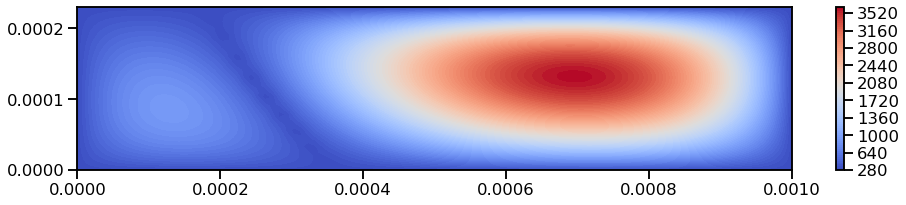

In [5]:
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
predict = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, predict, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

In [6]:
#model.restore('final/-5296.ckpt')

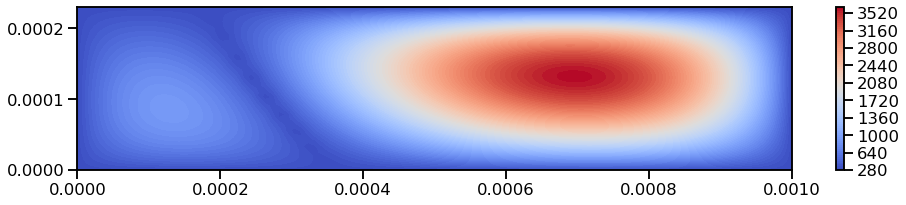

In [7]:
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
predict = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, predict, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

In [8]:
weights = np.ones(2)*1e-10
weights_2 = np.array([1, 1e-1])
model.compile("adam", lr=1e-5, loss_weights=weights*weights_2)
losshistory, train_state = model.train(epochs=1, display_every=1000)
weights = 1/np.array(losshistory.loss_train[0])

Compiling model...
'compile' took 10.206008 s



2023-03-01 10:09:20.412224: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1642] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or set the envvar XLA_FLAGS=--xla_hlo_profile.


Training model...

Step      Train loss              Test loss               Test metric
1         [7.63e+02, 8.38e+03]    [1.75e+03, 8.38e+03]    []  
2         [7.63e+02, 8.34e+03]    [1.75e+03, 8.34e+03]    []  

Best model at step 2:
  train loss: 9.10e+03
  test loss: 1.01e+04
  test metric: []

'train' took 20.829683 s



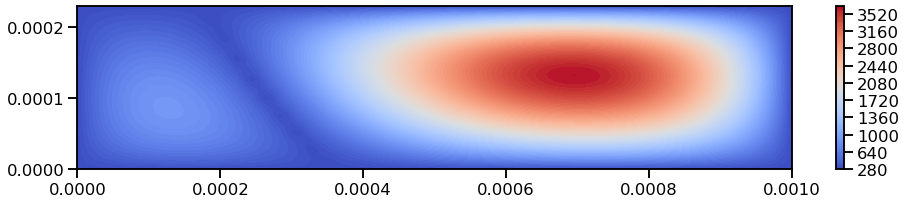

In [9]:
x_lin = np.linspace(0, x_max)
y_lin = np.linspace(0, y_max)
xx, yy, zz, tt = np.meshgrid(x_lin, y_lin, [z_max], [t_max])
X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(zz), np.ravel(tt))).T

Y = model.predict(X)

xi = np.linspace(xx.min(), xx.max(), 100)
yi = np.linspace(yy.min(), yy.max(), 100)
predict = griddata((np.ravel(xx), np.ravel(yy)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')

plt.figure(figsize = (16, 3))
plt.contourf(xi, yi, predict, 100, cmap=plt.cm.coolwarm)
plt.colorbar()

In [10]:
dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=3000, maxfun=3000, maxls=50)
model.compile('L-BFGS', loss_weights=weights*weights_2)
losshistory, train_state = model.train(display_every=100)

Compiling model...
'compile' took 10.278670 s

Training model...

Step      Train loss              Test loss               Test metric
2         [1.00e+00, 9.96e-02]    [2.29e+00, 9.96e-02]    []  
100       [1.27e-02, 6.77e-02]                                
200       [1.28e-02, 5.68e-02]                                
300       [1.29e-02, 4.72e-02]                                
400       [1.41e-02, 2.95e-02]                                
500       [1.16e-02, 2.37e-02]                                
600       [1.08e-02, 2.01e-02]                                
700       [9.64e-03, 1.69e-02]                                
800       [8.70e-03, 1.53e-02]                                
900       [8.02e-03, 1.43e-02]                                
1000      [7.87e-03, 1.34e-02]                                
1100      [7.67e-03, 1.28e-02]                                
1200      [7.38e-03, 1.24e-02]                                
1300      [7.25e-03, 1.16e-02]               

In [11]:
np.save('no_petrain', np.array(losshistory.loss_train))

In [11]:
np.save('pretrain', np.array(losshistory.loss_train))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

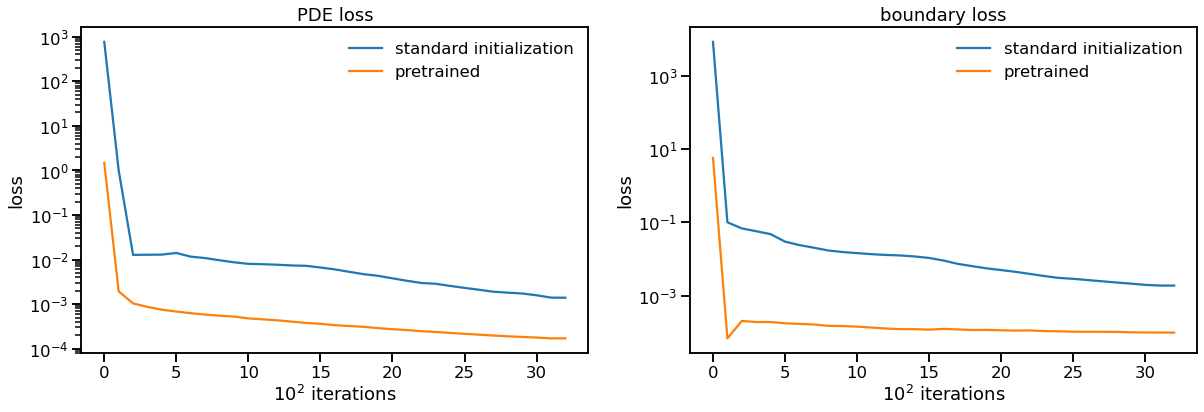

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 6))

ax1.set_yscale('log')
ax2.set_yscale('log')

for file, label in zip(['no_petrain.npy', 'pretrain.npy'], ['standard initialization', 'pretrained']):
    loss = np.load(file)
    ax1.plot(loss.T[0][3:], label = label)

for file, label in zip(['no_petrain.npy', 'pretrain.npy'], ['standard initialization', 'pretrained']):
    loss = np.load(file)
    ax2.plot(loss.T[1][3:], label = label)
    
ax1.legend(frameon=False)
ax2.legend(frameon=False)

ax1.set_title('PDE loss')
ax2.set_title('boundary loss')

ax1.set_xlabel(r'$10^2$ iterations')
ax2.set_xlabel(r'$10^2$ iterations')
ax2.set_ylabel('loss')
ax1.set_ylabel('loss')
#plt.xticks(plt.xticks()[0][1:-1], (plt.xticks()[0]*100)[1:-1])
plt.savefig('variation/pretrain.pdf', bbox_inches='tight')